In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import thermo
import matplotlib.pyplot as plt
%matplotlib inline

## Fire initialisation

### The fire initialisation is based on the model from [Rio et al. (2010)](https://acp.copernicus.org/articles/10/3463/2010/)
A simple parameterization based on assuming
- a bulk "heat of combustion" of the fuel $C$ (in kJ / kg)
- a density of burned biomass $\omega$ (in kg/m$^2$)
- a rectangular "line" geometry for the fire with:
  - width $L$
  - depth $d$
  - rate of spread (ROS) perpendicular to the line (equal at the front and the rear at any point along the line) $v$

If $C$, $L$, $v$ and $\omega$ are homogeneous over the released plume's time scale $T$, then over this time, the fire will have burnt its way over a distance $vT$, and swept an area

$A = LvT$.

Since the spatial energy density (in kJ/m$^{2}$) $E=\omega C$, the fire will then have released a total amount of energy

$E_t = E A = \omega C L v T$,

released energy (in kW) at a rate

$P = \frac{E_t}{T} = \omega C L v $,

which requires an average surface flux $F$ (in kW/m${^2}$) over the actively burning area $Ld$ of:

$F = \frac{P}{Ld} = \frac{\omega C v}{d}$.

$\omega C$ is usually estimated as a linear combination of all the different fuel species in the burning area, weighted by their area fraction. From this follows a definition for the "fire line intensity" (i.e. the heat flux *integrated over the fire depth*)

$I = \omega C v = Fd$.

The model assumes the heat is entirely sensible (no moisture), and that the final $F$ translated to the atmosphere is a fixed fraction $f_R$ of $F$, which accounts for the heat translated into radiative transfer away from the fire (and thus not diffused into the plume).

In [2]:
## All these parameters should come from a fire surface spread model.
# These are taken from Rio et al.'s estimate for the Chisholm fire
L_fire = 15000 # m
d_fire = 300 # m
C_fire = 17.781e6 # J / kg 
omega_fire = 7.6 # kg / m^2
v_fire = 1.5 # m / s
radiative_loss = 0.5 # fraction of F converted into radiative heating, and not into diffused into the atmosphere

S_fire = L_fire * d_fire
F_fire = omega_fire * C_fire * v_fire / d_fire * radiative_loss

## Plume initialisation

### Ambient profile
Here we start with creating the ambient environment through which the plume rises. Choose either
- to formulate an ambient profile yourself: `plume_init = 'idealised'`. If you choose this, set the idealised profiles `theta_l_e`, `q_t_e` and `pres_e` as a function of a defined `height`.
- to import an ambient profile from a sounding: `plume_init = 'radiosonde_env'`. If you choose this, specify the path to the radiosonde, and make sure this radiosonde contains pressure, relative humidity and temperature on a regridded height coordinate.

Pack this in a dataset with all other plume and environment characteristics. From here, we only pass this dataset around. The dataset will contain initial profiles for variables we will have to calculate:

**Mass flux variables**
- `entrainment`
- `detrainment`
- `mass_flux_plume`
- `w_p` (plume vertical velocity)
- `a_p` active plume area

**Plume and environmental thermodynamics**

Endings `_p` refer to plume variables; `_e` to environmental variables.
- Liquid-water potential temperature `theta_l`
- Total water specific humidity `q_t`
- Temperature `T`
- Liquid water specific humidity `q_l`
- Potential temperature `theta`
- Virtual potential temperature `theta_v`
- Pressure `pres` (assumed to be equal inside and outside the plume under the Boussinesq approximation)
- Density `rho` (same assumption as pressure)
- Buoyancy `buoyancy` (defined only for the plume)

These are all zero before we calculate anything.

In [3]:
plume_init = 'radiosonde_env'

if plume_init == 'radiosonde_env':
    
    fire = 'Martorell_2021-07-13'
    
    # Sounding must give at least T(z,t), rh(z,t) and pres(z,t)
#     ds_sou_e = pd.read_excel('radiosondes/'+fire+'/sonde_env.xlsx').set_index('z').to_xarray()
    ds_sou_e = (pd.read_csv('radiosondes/'+fire+'/plume_sounding/Martorell_2021-07-13_1818.sounding.csv',
                            header=1,
                            index_col='Height (m AGL)')
                           .to_xarray()
                           .rename({'Height (m AGL)':'z',
                                    ' Pressure (mb)':'p',
                                    ' Temperature (C)':'T',
                                    ' Relative humidity (%)':'rh'}))
    h_0 = ds_sou_e['z'][0].data
    height = ds_sou_e['z'].data
    
    # Check that these readings/conversions are correct
    pres_e = (ds_sou_e['p'] * 100).data # hPa -> Pa conversion
    T_e = (ds_sou_e['T'] + 273.15).data # C -> K conversion
    rh_e = (ds_sou_e['rh'] / 100).data # % -> fraction conversion
    
    # FIXME we are assuming explicitly that the environment is unsaturated (rh<1)
    q_t_e = rh_e * thermo.qsatur(T_e, pres_e)
    theta_l_e = thermo.calculate_theta(T_e, pres_e)

elif plume_init == 'idealised':
    # FIXME you are now operating with a profile of constant theta,
    # but this is inconsistent with the temperature lapse rates you use for the pressure. Just use these lapse rates, once you're sure it all works.
    h_0 = 20                                                              # Height above the surface (in m) where we initialise the model
    Gamma_thl = 6e-3 # K / km
    height = np.linspace(h_0,1e4,500)                                     # Vertical extent of the profile [m]
    
    theta_l_e = 300 + Gamma_thl*height                                    # environmental theta_l [K]
    q_t_e = 0.01 * np.ones(height.size)                                  # environmental q_t [kg / kg]
    pres_e = thermo.calculate_pressure(height, p_s=101300, theta_l_s=300) # environmental pressure [Pa]

# initialise the dataset based on these specifications
init_prof = np.zeros(height.size)

ds = xr.Dataset({'theta_l_e':('height', theta_l_e),
                 'q_t_e':('height', q_t_e),
                 'pres_e':('height', pres_e),
                 'theta_l_p':('height', np.copy(init_prof)),
                 'q_t_p':('height', np.copy(init_prof)),
                 'entrainment':('height', np.copy(init_prof)),
                 'detrainment':('height', np.copy(init_prof)),
                 'mass_flux_p':('height', np.copy(init_prof)),
                 'w_p':('height', np.copy(init_prof)),
                 'a_p':('height', np.copy(init_prof)),
                 'T_p':('height', np.copy(init_prof)),
                 'q_l_p':('height', np.copy(init_prof)),
                 'theta_p':('height', np.copy(init_prof)),
                 'theta_v_p':('height', np.copy(init_prof)),
                 'buoyancy_p':('height', np.copy(init_prof)),
                 'T_e':('height', np.copy(init_prof)),
                 'q_l_e':('height', np.copy(init_prof)),
                 'theta_e':('height', np.copy(init_prof)),
                 'theta_v_e':('height', np.copy(init_prof)),
                 'rho_e':('height', np.copy(init_prof)),
                },
                coords={'height':height})

# Calculate other initial environmental thermodynamic quantities from the environmental profiles of theta_l, q_t and pres
# Iterate over height to be explicit about what we do
for i in range(ds['height'].size):
    ds['T_e'][i], ds['q_l_e'][i], ds['theta_e'][i], ds['theta_v_e'][i] = thermo.calculate_thermo(ds['theta_l_e'][i], ds['q_t_e'][i], ds['pres_e'][i])

ds['rho_e'] = ds['pres_e']/thermo.rd/ds['T_e']

### Initial plume variables

To simulate the plume launched into the prescribed environment, we must specify initial conditions at height `h_0` for:
- Excess of `theta_l` above the ambient profile
- Excess of `q_t` above the ambient profile
- Updraft speed `w`

We can:
- read these off a sounding launched into the plume: `surface = 'radiosonde_plume'`
- compute them with a surface model: `surface = 'surface_scheme'`. Here we now just have the method by Rio et al. (2010)

In [4]:
surface = 'radiosonde'

## Plume model free parameters (related to mixing)
lambda_mix = 30 # Mixing length for detrainment within the mixed layer [m] (this is an assumption)
height_surface_layer = 100
beta = 1 # entrainment / detrainment ratio

## Initial (lowest level) values for the plume
# Should come from a separate fire=>flux interface, e.g. from the Rothermel model, but let's start simple

# Plume thermodynamics
if surface == 'radiosonde':
    # These values currently just come from Marc...
    d_theta_l_0 = 1 # [K]
    d_q_t_0 = 0.001 # [kg / kg]
    ds['w_p'][0] = 1. # m/s
    l_fire = 10000 # m, assumed fire length scale
elif surface == 'surface_scheme':
    # Surface model from Rio et al. (2010); eqs. 12, 19 and the definitions
    # F_fire = rho*cp*wu*theta_v',
    # F_q_fire = rho*wu*q'
    # And assuming the buoyancy flux is entirely dominated by sensible heat (q' does not impact F_fire)
    F_q_fire = 0.5 # [kg/kg] Can do this following Luderer et al, would be better...
    ds['w_p'][0] = (3 * thermo.grav * F_fire * h_0 / (2 * ds['rho_e'][0] * thermo.cp * ds['theta_v_e'][0]))**(1./3)
    d_theta_l_0 = F_fire / (ds['rho_e'][0] * thermo.cp * ds['w_p'][0])
    d_q_t_0 = F_q_fire / (ds['rho_e'][0] * thermo.cp * ds['w_p'][0])
    
    # Fire length scale [m]
    l_fire = np.sqrt(S_fire)


# Add excess temperature and moisture to the first model level of the plume
ds['theta_l_p'][0] = ds['theta_l_e'][0] + d_theta_l_0
ds['q_t_p'][0] = ds['q_t_e'][0] + d_q_t_0

# FIXME: this model for w_p/theta_v_p ignores any virtual (water vapour) contributions to the initial buoyancy flux
# (F_fire is entirely composed of sensible heat)
ds['T_p'][0], ds['q_l_p'][0], ds['theta_p'][0], ds['theta_v_p'][0] = thermo.calculate_thermo(ds['theta_l_p'][0], ds['q_t_p'][0], ds['pres_e'][0])
ds['buoyancy_p'][0] = thermo.grav / ds['theta_v_e'][0] * (ds['theta_v_p'][0] - ds['theta_v_e'][0])

# Initialise plume mass flux and entrainment
ds['a_p'][0] = S_fire # (Dimensional) plume area
ds['mass_flux_p'][0] = ds['rho_e'][0] * ds['a_p'][0] * ds['w_p'][0]
ds['entrainment'][0] = (ds['a_p'][0] * ds['rho_e'][0]) / (2 * ds['w_p'][0]) * ds['buoyancy_p'][0]

## Plume ascent

In [5]:
crossed_surface_layer = False 

# Explicitly iterate through the profile, for clarity
dz = ds['height'].diff('height')

# Use all values at height index i-1 to calculate the values at height index i (simple forward Euler)
# From the model by Rio et al. (2010), which assumes:
# - plume area * density = constant, i.e. acceleration is balanced by entrainment (were there no detrainment)
# - erosion of the plume (detrainment) with a mixing length lambda_mix

for i in range(1, ds['height'].size):
# for i in range(1, 4):

    # Mass flux through plume
    ds['mass_flux_p'][i] = ds['mass_flux_p'][i-1] + (ds['entrainment'][i-1] - ds['detrainment'][i-1]) * dz[i-1]
    
    # Thermodynamics
    ds['theta_l_p'][i] = ds['theta_l_p'][i-1] + ds['entrainment'][i-1] * (ds['theta_l_e'][i-1] - ds['theta_l_p'][i-1]) / ds['mass_flux_p'][i-1] * dz[i-1]
    ds['q_t_p'][i] = ds['q_t_p'][i-1] + ds['entrainment'][i-1] * (ds['q_t_e'][i-1] - ds['q_t_p'][i-1]) / ds['mass_flux_p'][i-1] * dz[i-1]
    ds['T_p'][i], ds['q_l_p'][i], ds['theta_p'][i], ds['theta_v_p'][i] = thermo.calculate_thermo(ds['theta_l_p'][i], ds['q_t_p'][i], ds['pres_e'][i])
    ds['buoyancy_p'][i] = thermo.grav / ds['theta_v_e'][i] * (ds['theta_v_p'][i] - ds['theta_v_e'][i])
        
    # Vertical velocity
    # This equation is not well-constrained by theory. Romps & Charn (2016) argue for form drag, but I find the best
    # results if I simply do not simulate any drag, and let only buoyancy act on the plume.
    # In the language of de Roode et al. (2012): a=1, b=0
    a=1; b=0
    ds['w_p'][i] = (-b * ds['entrainment'][i-1] * ds['w_p'][i-1] + a * ds['a_p'][i-1] * ds['rho_e'][i-1] * ds['buoyancy_p'][i-1]) / ds['mass_flux_p'][i-1] * dz[i-1] + ds['w_p'][i-1]
    
    # Entrainment and detrainment in the surface layer
    # This is the entrainment needed to keep the plume cross-section constant. Detrainment is simply an erosion assumption.
    ds['entrainment'][i] = (ds['a_p'][i-1] * ds['rho_e'][i-1]) / (2 * ds['w_p'][i-1]) * ds['buoyancy_p'][i-1]
    ds['detrainment'][i] = ds['a_p'][i-1] * ds['rho_e'][i-1] * np.sqrt(lambda_mix) / l_fire * (np.sqrt(ds['height'][i]) * (ds['w_p'][i] - ds['w_p'][i-1]) / dz[i-1] +
                                                                                               ds['w_p'][i-1] / (2 * np.sqrt(ds['height'][i]))
                                                                                              )
    # Entrainment and detrainment above the surface layer
    # Siebesma & Holtslag (1996) - like, using the value at the (still unconstrained) surface layer height
    if ds['height'][i] > height_surface_layer:
        if not crossed_surface_layer:
            epsi = ds['entrainment'][i] / ds['mass_flux_p'][i]
            delt = epsi / beta
            crossed_surface_layer = True
        
        ds['entrainment'][i] = epsi * ds['mass_flux_p'][i]
        ds['detrainment'][i] = delt * ds['mass_flux_p'][i]
    
    # Update area fraction to be consistent with the new mass flux, vertical velocity and density
    ds['a_p'][i] = ds['mass_flux_p'][i] / (ds['rho_e'][i] * ds['w_p'][i])
    
    # Discontinuous plume top where the plume is no longer ascending, or the area is zero
    if ds['w_p'][i] < 0 or ds['a_p'][i] < 0:
        # Above this height, complete the plume thermodynamic profiles so they are the same as the environment
        ds['theta_l_p'][i:] = ds['theta_l_e'][i:]
        ds['q_t_p'][i:] = ds['q_t_e'][i:]
        ds['T_p'][i:] = ds['T_e'][i:]
        ds['q_l_p'][i:] = ds['q_l_e'][i:]
        ds['theta_p'][i:] = ds['theta_e'][i:]
        ds['theta_v_p'][i:] = ds['theta_v_e'][i:]
        
        # And set the plume area to a nan
        ds['a_p'][i:] = np.nan
        break



In [6]:
# Import validation plume dataset from the Martorell fire
ds_sou_p = (pd.read_csv('radiosondes/'+fire+'/plume_sounding/Martorell_2021-07-13_1805.raw_flight_history.csv',
#                             header=1,
                            index_col=' Altitude (m AGL)')
                           .to_xarray()
                           .rename({' Altitude (m AGL)':'z',
                                    ' Pressure (Pascal)':'p',
                                    ' Temperature (C)':'T',
                                    ' Relative humidity (%)':'rh',
                                    ' Rise speed (m/s)':'w'}))


ds_sou_p['pres_p'] = ds_sou_p['p']
ds_sou_p['T_p'] = ds_sou_p['T'] + 273.15 # C -> K conversion
ds_sou_p['rh_p'] = ds_sou_p['rh'] / 100 # % -> fraction conversion
ds_sou_p['q_t_p'] = ds_sou_p['rh_p'] * thermo.qsatur(ds_sou_p['T_p'], ds_sou_p['pres_p'])
ds_sou_p['theta_l_p'] = thermo.calculate_theta(ds_sou_p['T_p'], ds_sou_p['pres_p']) # < if the plume is unsaturated!!

ds_sou_p['q_l_p'] = ds_sou_p['rh_p'].copy()
ds_sou_p['theta_p'] = ds_sou_p['rh_p'].copy()
ds_sou_p['theta_v_p'] = ds_sou_p['rh_p'].copy()
for i in range(ds_sou_p['z'].size):
    ds_sou_p['T_p'][i], ds_sou_p['q_l_p'][i], ds_sou_p['theta_p'][i], ds_sou_p['theta_v_p'][i] = thermo.calculate_thermo(ds_sou_p['theta_l_p'][i], ds_sou_p['q_t_p'][i], ds_sou_p['pres_p'][i])

Compared to Marc's data, the entrainment rates from the model seem too low. How can we enhance them?

Text(0.5, 0, 'Liquid water [kg/kg]')

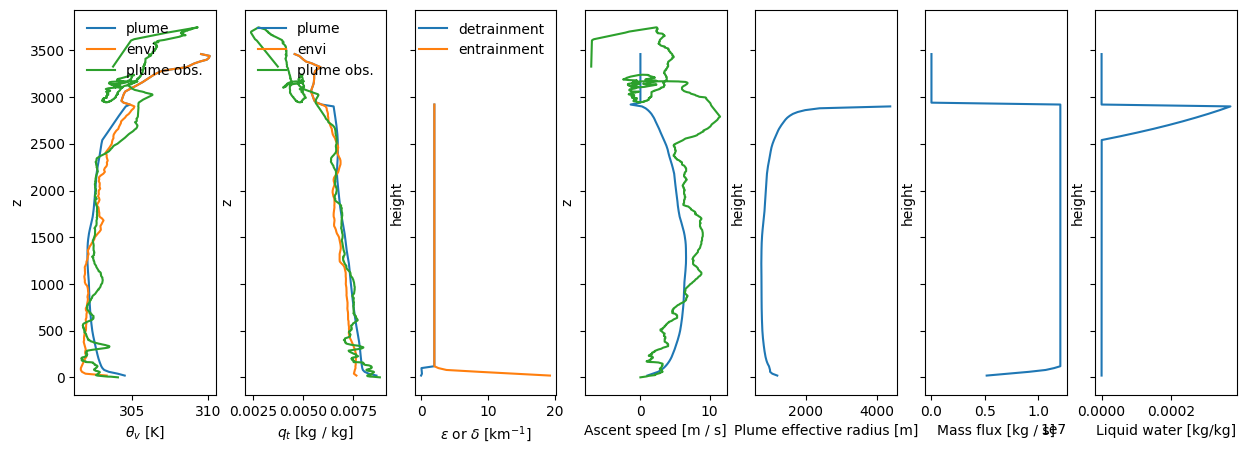

In [7]:
validation = True
zmax = 3500

fig, axs = plt.subplots(ncols=7, figsize=(15,5), sharey=True)
ds['theta_v_p'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='plume')
ds['theta_v_e'].sel(height=slice(0,zmax)).plot(y='height',ax=axs[0], label='envi')
if validation:
    ds_sou_p['theta_v_p'].plot(y='z', ax=axs[0],label='plume obs.')
axs[0].legend(bbox_to_anchor=(0,1), loc='upper left', frameon=False)
axs[0].set_xlabel(r'$\theta_v$ [K]')

(ds['q_t_p']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='plume')
(ds['q_t_e']).sel(height=slice(0,zmax)).plot(y='height',ax=axs[1], label='envi')
if validation:
    ds_sou_p['q_t_p'].plot(y='z', ax=axs[1], label='plume obs.')
axs[1].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
axs[1].set_xlabel('$q_t$ [kg / kg]')

(ds['detrainment']/ds['mass_flux_p']*1000).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2], label='detrainment')
(ds['entrainment']/ds['mass_flux_p']*1000).sel(height=slice(0,zmax)).plot(y='height', ax=axs[2], label='entrainment')
axs[2].legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
axs[2].set_xlabel(r'$\varepsilon$ or $\delta$ [km$^{-1}$]')

(ds['w_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[3])
if validation:
    ds_sou_p['w'].plot(y='z', ax=axs[3], c='C2')
axs[3].set_xlabel('Ascent speed [m / s]')
    
(np.sqrt(ds['a_p'] / np.pi)).sel(height=slice(0,zmax)).plot(y='height', ax=axs[4])
axs[4].set_xlabel('Plume effective radius [m]')

ds['mass_flux_p'].sel(height=slice(0,zmax)).plot(y='height', ax=axs[5])
axs[5].set_xlabel('Mass flux [kg / s]')

(ds['q_l_p']).sel(height=slice(0,zmax)).plot(y='height', ax=axs[6])
axs[6].set_xlabel('Liquid water [kg/kg]')

### TODO
- Get some (radiosonde) data to validate against
- When to stop the model?
- Cannot assume the entrainment/detrainment behaves like in the mixing layer throughout the free troposphere
  - Constrain entrainment > 0?
  - Change detrainment formulation above mixed layer top?
- Make the surface model more consistent with
  - The Luderer approach (to constrain the initial moisture addition)
  - The Rothermel scheme
- Include the modification of the plume environment, by the detrainment from the plume (to test Marc's fireABL idea)
- How to include:
  - Wind deformation of the plume
  - Multiple plumes

For model construction, we need to think about the following use cases:
- Simulating idealised profiles, set by different plume controlling factors (stability, moisture in atmosphere, fire intensity, wind speed, entrainment/detrainment ratio), for teaching purposes
- Running with different surface representations (Rothermel, Luderer, just prescribing initial conditions from a radisonde)
- Probably also running with different plume formulations

If you want all this, we will need to build modularity.
